In [49]:
# Adding the neccecary imports to our code
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydot # conda install pydot
import time
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import math

In [50]:
#type of data:
url_Les_Miserables_network  = '../data/LesMiserables.dot'
url_Rome_graph  = '../data/rome.dot'
url_Jazz_Network  = '../data/JazzNetwork.dot'
url_Small_Directed_Network  = '/content/noname.dot'
url_Pro_League_Network  = '/content/LeagueNetwork.dot'
url_Argumentation_network  = '../data/devonshiredebate_withclusters.dot'
url_Political_blogosphere_network  = '../data/polblogs.dot'

In [51]:
# classes
class Vertex:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y
        self.neighbors = []
        ######################################################
        self.parents = []
        self.children = []
        #####################################################
    def add_neighbor(self,neighbor):
        self.neighbors.append(neighbor)
    ######################################################
    def add_parents(self,parent):
        self.parents.append(parent)
    def add_children(self,child):
        self.children.append(child)


class Edge:
    def __init__(self, start, end):
        self.start = start
        self.end = end

class Graph:
    def __init__(self):
        self.vertices = []
        self.edges = []

    def add_vertex(self, vertex):
        self.vertices.append(vertex)

    def add_edge(self, edge):
        self.edges.append(edge)

    def get_vertex(self, id):
        for vertex in self.vertices:
            if vertex.id == id:
                return vertex
    ###############################################################
    def remove_edge(self, start, end):
        for edge in self.edges:
            if edge.start == start and edge.end == end:
                self.edges.remove(edge)

    def remove_vertex(self, id):
        for vertex in self.vertices:
            if vertex.id == id:
                self.vertices.remove(vertex)
    ################################################################
    def update_x_y(self,id,x,y):
      for vertex in self.vertices:
            if vertex.id == id:
              vertex.x = x
              vertex.y = y
    ############################################################

    def visualize_graph(self, custom_figsize, radius):  # O(V + V + E) = O(2V + E) = O(V + E)

      self.place_vertices_in_circle(radius)  # O(V)

      fig, ax = plt.subplots(figsize=(custom_figsize, custom_figsize))  # Adjust width and height as needed
      # Plot Vertices
      scaling_factor = 1 / len(self.vertices)
      for vertex in self.vertices:  # O(V)
          ax.scatter(vertex.x, vertex.y, color='blue', zorder=2, s=scaling_factor * 40000 * (custom_figsize / 15),
                    edgecolors='black')
          ax.text(vertex.x, vertex.y, str(vertex.id), fontsize=(scaling_factor * 40000 * (custom_figsize / 15)) / 100,
                  ha='center', va='center', zorder=len(self.vertices) * scaling_factor * 2, color='white')
      # Plot edges with direction
      for edge in self.edges:  # O(E)
          start = edge.start
          end = edge.end
          dx = end.x - start.x
          dy = end.y - start.y
          ax.annotate("", xy=(end.x, end.y), xytext=(start.x, start.y),
                      arrowprops=dict(arrowstyle="->", linewidth=2.0, color='gray'))

      ax.set_xlabel('X')
      ax.set_ylabel('Y')
      ax.set_title('Graph Visualization with Edge Direction')
      ax.grid(True)
      plt.show()


    def place_vertices_in_circle(self,radius): # O(V)
        num_vertices = len(self.vertices)
        radius = radius  # Radius of the circle
        center_x = 0
        center_y = 0
        angle_increment = 4 * np.pi / num_vertices

        # Place vertices in a bit of randomized circle
        for i, vertex in enumerate(self.vertices): # O(V)
            angle = i * angle_increment
            vertex.x = center_x + radius * np.cos(angle)
            vertex.y = center_y + radius * np.sin(angle)




In [52]:
def create_custom_graph(G): # O(V) + O(E) + O(V) + O(E) = O(2V + 2E) = O(V + E)
    # Parsing the vertices and edges from the generated graph into lists
    vertices = [n.get_name() for n in G.get_node_list()] # O(V)

    edges = [(edge.get_source(),edge.get_destination(),edge.get_weight()) for edge in G.get_edge_list()] # O(E)
    graph = Graph()
    for vertex in vertices: # O(V)
      vertex = Vertex(vertex, 0, 0)  # Initialize the vertex with ID and default coordinates
      graph.add_vertex(vertex)

    for edge in edges: # O(E)
        source_vertex = graph.get_vertex(edge[0])
        neighbor_vertex = graph.get_vertex(edge[1])

        if source_vertex is None:
            source_vertex = Vertex(edge[0], 0, 0)
        if neighbor_vertex is None:
            neighbor_vertex = Vertex(edge[1], 0, 0)
        source_vertex.add_neighbor(neighbor_vertex)
        ################################################adding outgoing ingoing##########################
        source_vertex.add_children(neighbor_vertex)
        neighbor_vertex.add_parents(source_vertex)
        #################################################################################################
        graph.add_edge(Edge(source_vertex, neighbor_vertex))

    return graph

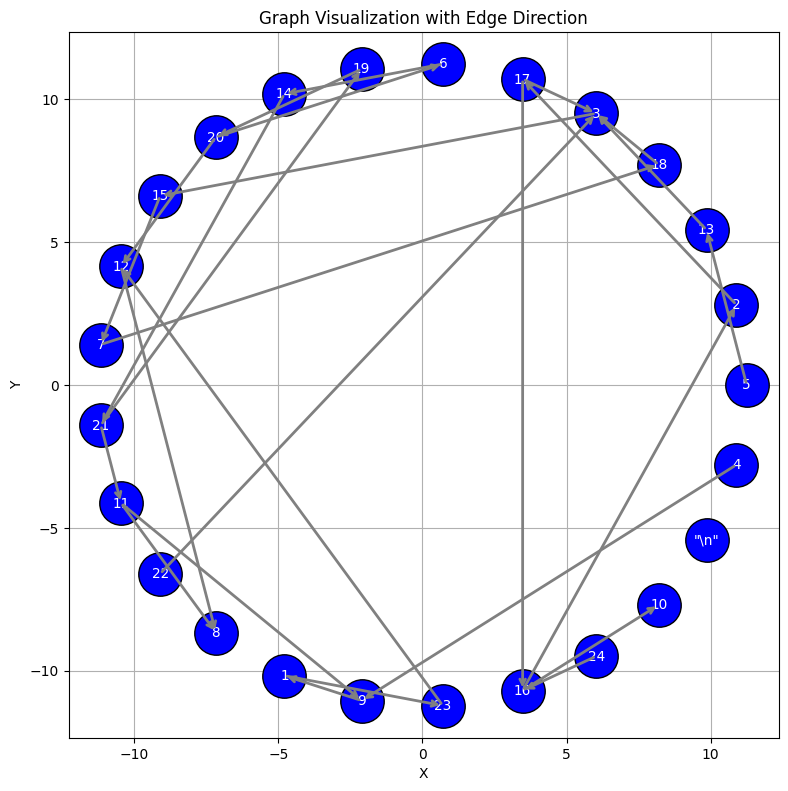

In [53]:
# Parsing the data from the dot file:
G = pydot.graph_from_dot_file(url_Small_Directed_Network)[0]
#Convering the graph into our custom graph
graph = create_custom_graph(G) #O(V) + O(E) = O(V + E)
# Visualize the graph

fig_size=5+len(graph.vertices)/6 # new line
radius=5+len(graph.vertices)/4 # new line

graph.visualize_graph(fig_size,radius) #O(V + E)




In [54]:
def remove_sink_vertices(G, h_graph):#O(V*(V+V*E))=O(E*V^2)
  sink = 1
  #untile there is no other sink node
  while sink == 1:

      sink = 0
      for v1 in G.vertices:#O(V*(V+V*E))=O(E*V^2)

        #if it doesnt have children then is sink add them to the sink graph
        if not v1.children:
          sink = 1

          #add sink node to the new graph
          h_graph.add_vertex(v1)

          #remove node from original
          G.remove_vertex(v1.id) #O(V)

          for v2 in v1.parents:#O(V*E)
            #Add sink edges to the new graph
            h_graph.add_edge(Edge(v2, v1))

            #remove edges from original
            G.remove_edge(v2, v1)#O(E)
            #remove v1 as parent of v2
            v2.children.remove(v1)

  return G, h_graph



def remove_source_vertices(G, h_graph):#O(V*(V+V*E))=O(E*V^2)
  source = 1
  #untile there is no other source node
  while source == 1:

      source = 0
      for v1 in G.vertices:#O(V*(V+V*E))=O(E*V^2)

        #if it doesnt have parent then is source add them to the source graph
        if not v1.parents:
          source = 1

          #add sorce node to the new graph
          h_graph.add_vertex(v1)
          #remove node from original
          G.remove_vertex(v1.id)

          for v2 in v1.children:
            #Add source edge to the new graph
            h_graph.add_edge(Edge(v1, v2))

            #remove edges from original
            G.remove_edge(v1, v2)
            #remove v1 as parent of v2
            v2.parents.remove(v1)

  return G, h_graph

def remove_maximal_vertex(G, h_graph, reverse_edges):#O(V^2(E+V))

  #if the graph its not empty
  if bool(G.vertices):

      #initialize the first value for the vertex with maximume difference of ingoing and outgoing edges
      current_vertex = G.vertices[0]
      max = abs(len(current_vertex.parents)-len(current_vertex.children))

      #check every node and get the maximal
      for v1 in G.vertices:#O(V^2(E+V))
        cur = abs(len(v1.parents)-len(v1.children))

        if cur > max:
          max = cur
          current_vertex = v1
        #if there are 2 take the one with the fewest number of ingoing edges
        if cur == max:
          if len(v1.parents) < len(current_vertex.parents):
            max = cur
            current_vertex = v1

      #add current vertex to the new graph
      h_graph.add_vertex(current_vertex)

      #remove current vertex from original
      G.remove_vertex(current_vertex.id) #O(V)

      for c in current_vertex.children:#O(V(E+V))
        #Add source edge to the new graph
        h_graph.add_edge(Edge(current_vertex, c))

        #remove edges from original
        G.remove_edge(current_vertex, c)#O(E)
        #remove v1 as parent of v2
        c.parents.remove(current_vertex)#O(V)

      #add the ingoing esges to the reverse edges
      for p in current_vertex.parents:#O(V)
        reverse_edges.append(Edge(p, current_vertex))

  return G, h_graph, reverse_edges

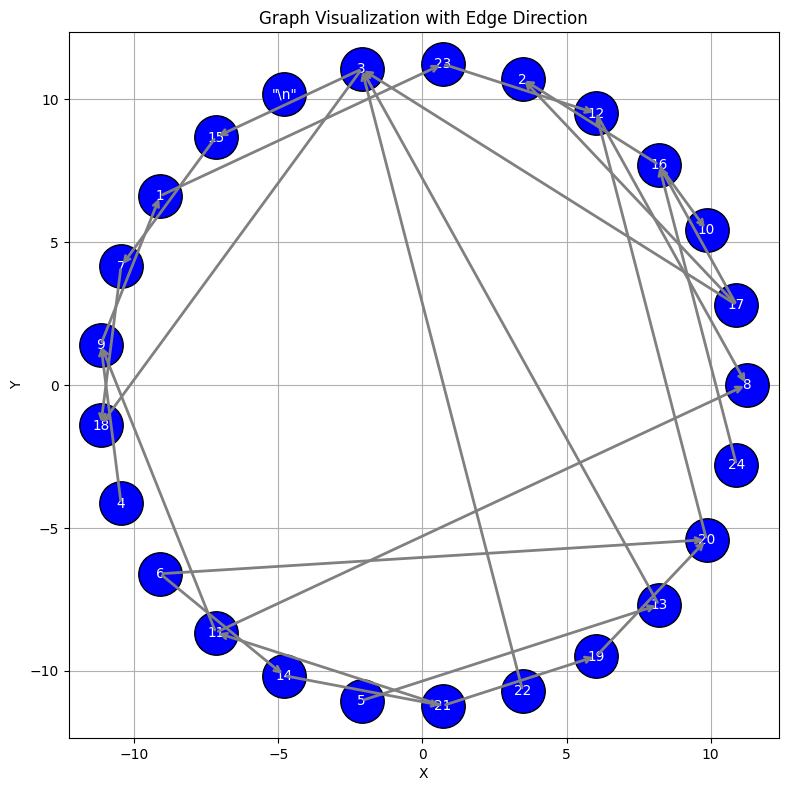

In [55]:

def heuristic_guarantees(G): #O(EV^3 + V^4)

  h_graph = Graph()
  reverse_edges = []

  while G.vertices:#O(V*2*E*V^2+V^2E+V^3+E) =O(V*(2*(E*V^2)+ (E+V)*V^2)) = O(2EV^3 + EV^3 + V^4) = O(EV^3 + V^4)


    G, h_graph = remove_sink_vertices(G, h_graph)#O(E*V^2)

    G, h_graph = remove_source_vertices(G, h_graph)#O(E*V^2)

    G, h_graph, reverse_edges = remove_maximal_vertex(G,h_graph, reverse_edges)#O(V^2(E+V))


  #add the reversed edges
  for reverse in reverse_edges:#O(E)
    h_graph.remove_edge(reverse.start, reverse.end)
    h_graph.add_edge(Edge(reverse.end, reverse.start))

  return(h_graph,reverse_edges)

import copy
copied_graph = copy.deepcopy(graph)
dag, reverse_edges = heuristic_guarantees(copied_graph)

# Visualize the graph###################################################
fig_size=5+len(dag.vertices)/6 # new line
radius=5+len(dag.vertices)/4 # new line
dag.visualize_graph(fig_size,radius) #O(V + E)


for v in dag.vertices:
  if v.id == '"\\n"':
      dag.vertices.remove(v)

In [56]:

def update_parents_children(G):#O(V+E)

  #clear list of parents and childrens
  for vertex in G.vertices:
    vertex.parents.clear()
    vertex.children.clear()

  #add the parents and children based on the edges
  for edge in G.edges:
    edge.start.add_children(edge.end)
    edge.end.add_parents(edge.start)

  return(G)


def sources_of_graph(G):#O(V)
  sources = []
  #take all the source nodes of current graph
  for v in G.vertices:
    if not v.parents:
      sources.append(v)

  return(sources)

def update_graph(G, sources):#O(V^3+V^2E)

  #remove the source vertices from the graph
  for v in sources:#O(V(V+VE+V^2)) = O(V^3+V^2E)
    G.remove_vertex(v.id)#O(V)

    #remove the edges of the source vertices of the graph
    for c in v.children:#O(VE+V^2)
      #remove edges from original
      G.remove_edge(v, c)#O(E)
      #remove v as parent of c
      c.parents.remove(v)#O(V)

  return(G)

def layer_assignment(G):#O(V^4+V^3E)

  #get the source vertices
  sources = sources_of_graph(G)#O(V)
  layers = []

  #until there is no ant more source vertices
  while sources:#O(V(V^3+V^2E+V))= O(V^4+V^3E)
    layers.append(sources)
    G = update_graph(G, sources)#O(V^3+V^2E)
    sources = sources_of_graph(G)#O(V)

  return(layers)

copied_graph = copy.deepcopy(dag)
copied_graph = update_parents_children(copied_graph)#O(V+E)
layers = layer_assignment(copied_graph)

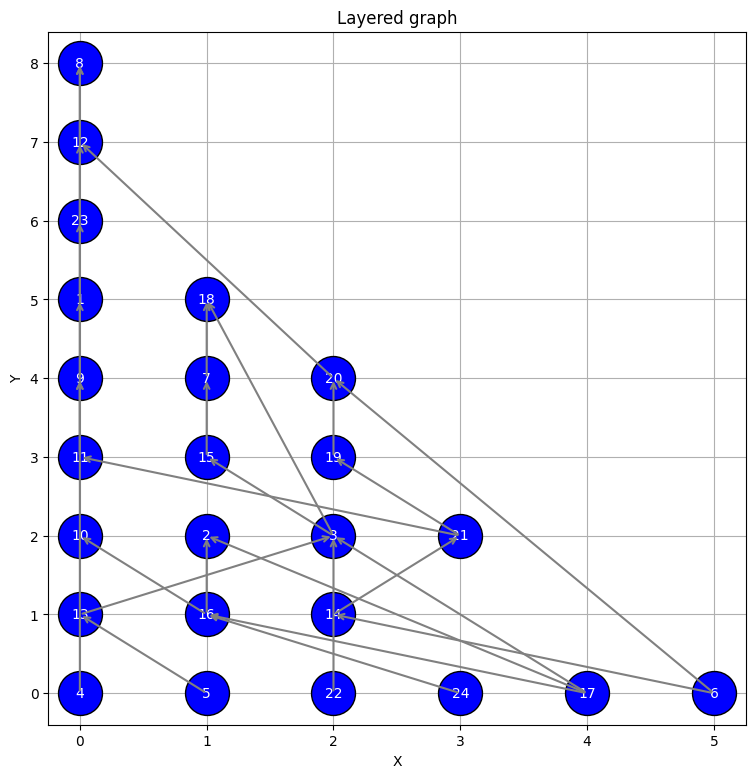

In [57]:

def visualize_layerd_graph(layers, G, fig_size, radius):
  fig, ax = plt.subplots(figsize=(fig_size, fig_size))  # Adjust width and height as needed
  # Plot Vertices
  scaling_factor = 1 / len(G.vertices)

  #visualize the nodes based on their position on the layers
  for idx,layer in enumerate(layers):#total O(v^2)
      for idx1,vertex in enumerate(layer):#O(V)for both of the loops it runs for all the layers in the loop
          G.update_x_y(vertex.id, idx1, idx)#O(V)
          ax.scatter(idx1, idx, color='blue', zorder=2, s=scaling_factor * 40000 * (fig_size / 15),
                    edgecolors='black')
          ax.text(idx1, idx, str(vertex.id), fontsize=(scaling_factor * 40000 * (fig_size / 15)) / 100,
                  ha='center', va='center', zorder=len(G.vertices) * scaling_factor * 2, color='white')
  #visualize edges
  for edge in G.edges:#O(E)
        start = edge.start
        end = edge.end
        dx = end.x - start.x
        dy = end.y - start.y
        ax.annotate("", xy=(end.x, end.y), xytext=(start.x, start.y),
                    arrowprops=dict(arrowstyle="->", linewidth=1.5, color='gray'))

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_title('Layered graph')
  ax.grid(True)
  plt.show()


copied_graph = copy.deepcopy(dag)
fig_size=5+len(copied_graph.vertices)/6 # new line
radius=5+len(copied_graph.vertices)/4 # new line

visualize_layerd_graph(layers, copied_graph, fig_size, radius)#O(v^2+E)



In [58]:
def insert_dummies(layers, G):#O(V^2+EL+E^2)

  #update coordinates
  for idx, layer in enumerate(layers):
    for idx1, vertex in enumerate(layer):#TOTAL O(V^2)
      G.update_x_y(vertex.id, idx1, idx)#O(V)

  dummy_num = 0
  edges = G.edges[:]
  for edge in edges:#O(E(L+E))=O(EL+E^2)
      start = edge.start
      end = edge.end

      # Check if the edge spans more than 1 layer
      if abs(start.y - end.y) > 1:
          # total number of dummies required for the current edge
          numberOfDum=abs(start.y - end.y)-1
          add_factor= 0

          prev_vertex = start
          next_vertex = None

          #until we put all the dummies on the graph
          while numberOfDum > 0:#O(L) L max number of layers -2

              add_factor =add_factor + 1
              #current layer
              dummy_layer = min(start.y, end.y) + add_factor

              #create the dummy
              dummy_id ="D"+ str(dummy_num)+"_s"+str(start.id)+"_e"+str(end.id)
              dummy_vertex = Vertex(dummy_id, 0, 0)
              G.add_vertex(dummy_vertex)


              #put the dummy in the right layer over its parent
              layers[dummy_layer].insert(start.x, dummy_vertex)


              #add the edges
              next_vertex = dummy_vertex
              G.add_edge(Edge(prev_vertex,next_vertex))

              prev_vertex = next_vertex

              numberOfDum = numberOfDum - 1
              dummy_num+=1

          #add the new edge
          G.add_edge(Edge(prev_vertex,end))
          #remove the direct node
          G.remove_edge(start, end)#O(E)

  return layers, G

layered_dummies_graph = copy.deepcopy(dag)
layers, layered_dummies_graph = insert_dummies(layers, layered_dummies_graph)


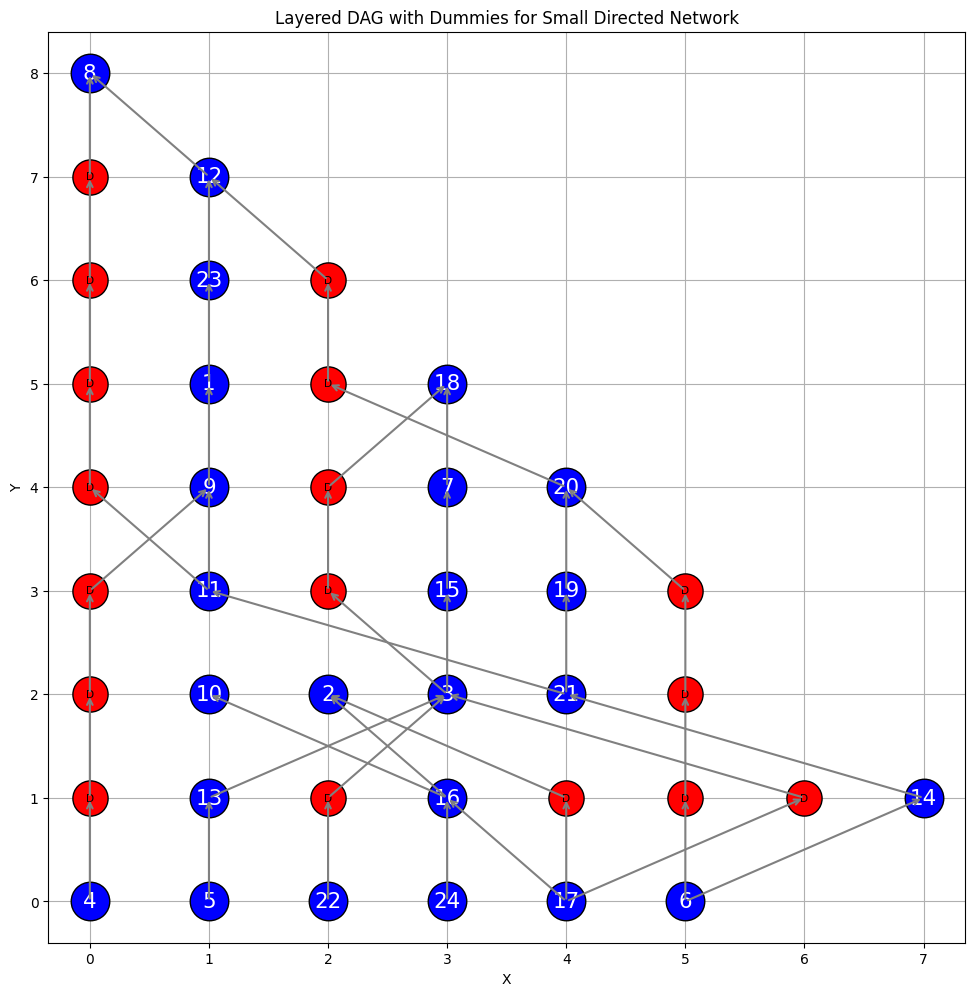

In [59]:

def visualize_layered_graph_with_dummies(layers, G, fig_size, radius):#O(V^2+E)

    fig, ax = plt.subplots(figsize=(fig_size, fig_size))  # Adjust width and height as needed

    # Plot Vertices
    scaling_factor = 1 / len(G.vertices)
    #visualize nodes based on their position in the layer
    for idx,layer in enumerate(layers):
        for idx1,vertex in enumerate(layer):#O(V^2)
            #update_x_y
            G.update_x_y(vertex.id, idx1, idx)#O(V)
            if vertex.id.startswith("D"):
              ax.scatter(idx1, idx, color='red', zorder=2, s=(scaling_factor * 40000 * (fig_size / 15))/1.2,
                        edgecolors='black')
              ax.text(idx1, idx, "D", fontsize=(scaling_factor * 40000 * (fig_size / 15)) / 100,
                      ha='center', va='center', zorder=len(G.vertices) * scaling_factor * 2, color='black')
            else:
              ax.scatter(idx1, idx, color='blue', zorder=2, s=scaling_factor * 40000 * (fig_size / 15),
                      edgecolors='black')
              ax.text(idx1, idx, str(vertex.id), fontsize=(scaling_factor * 40000 * (fig_size / 15)) / 50,
                    ha='center', va='center', zorder=len(G.vertices) * scaling_factor * 2, color='white')

    #visualize edges
    for edge in G.edges:#O(E)
        start = edge.start
        end = edge.end
        dx = end.x - start.x
        dy = end.y - start.y
        ax.annotate("", xy=(end.x, end.y), xytext=(start.x, start.y),
                    arrowprops=dict(arrowstyle="->", linewidth=1.5, color='gray'))

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Layered DAG with Dummies for Small Directed Network',)
    ax.grid(True)
    plt.show()




fig_size=5+len(layered_dummies_graph.vertices)/6 # new line
radius=5+len(layered_dummies_graph.vertices)/4 # new line


visualize_layered_graph_with_dummies(layers, layered_dummies_graph, fig_size, radius)



In [60]:
#GENERAL FUNTIONS######################################################
from itertools import permutations

def update_parents_children_in_layers(layers, edges):#O(VE)
  for layer in layers:
    for vertex in layer:
      vertex.parents.clear()
      vertex.children.clear()

  for layer in layers:
    for vertex in layer:
      for edge in edges:
        if vertex.id == edge.end.id:
          vertex.parents.append(edge.start)

        if vertex.id == edge.start.id:
          vertex.children.append(edge.end)

def get_index(layer, target_id):#O(V)

    #find the id on the ayers and get the index
    for idx, vertex in enumerate(layer):
        if vertex.id == target_id:
            return idx
    return None

def calculate_total_crossing(layers):

    crossing_count = 0
    #for each pair of consecutive layers
    for idx, layer in enumerate(layers[:-1]):#O(L)
        first_layer = layer
        second_layer = layers[idx+1]

        #check for every current node in the layer for every other node that is after the current node
        for i in range(len(second_layer)):
          for j in range(i + 1, len(second_layer)):

            #for each parent of the  current node check if there is a parent of the other node that is positioned before the parent of the current node
            for parent_v1 in second_layer[i].parents:
              #get the index of the parent of the first node
              pv1_idx = get_index(first_layer, parent_v1.id)


              for parent_v2 in second_layer[j].parents:
                #get the index of the parent of the second node
                pv2_idx = get_index(first_layer, parent_v2.id)

                #if the parent of v1 is after the parent of v2 it means there is a crossing
                if pv1_idx > pv2_idx:
                  crossing_count +=1

    return(crossing_count)


In [61]:
#BARYCENTER #################################################
def rearange_of_layers_Barycenter(first_layer, second_layer):#O(V^3)

  for vertex in second_layer:#O(V)

    deg = len(vertex.parents)
    sum = 0
    for parent in vertex.parents:#O(V^2)
      sum += get_index(first_layer, parent.id)#O(V)

    if deg == 0:
      continue
    vertex_x = 1/deg * sum

    vertex.x = vertex_x

  second_layer = sorted(second_layer, key=lambda vertex: vertex.x)#O(V)
  return (second_layer)


def rearange_of_layers_reverse_Barycenter(first_layer, second_layer ):#O(V^3)

  for vertex in first_layer:
    deg = len(vertex.children)
    sum = 0
    for child in vertex.children:
      sum += get_index(second_layer, child.id)

    if deg == 0:
      continue
    vertex_x = 1/deg * sum

    vertex.x = vertex_x

  first_layer = sorted(first_layer, key=lambda vertex: vertex.x)
  return (first_layer)


In [62]:
#MEDIAN ###################################################################
def custom_sort_key_a(vertex):

  if (len(vertex.parents)) % 2 == 1 :
      return (vertex.x, 0)
  else:
      return (vertex.x, 1)

def custom_sort_key_b(vertex):
    if (len(vertex.children) ) % 2 == 1 :
        return (vertex.x, 0)
    else:
        return (vertex.x, 1)

def rearange_of_layers_median(first_layer, second_layer):

  for vertex in second_layer:#O(V)

    parents_idx = []
    #get the index of the neighboars of the current node
    for parent in vertex.parents:#O(V)
      parents_idx.append(get_index(first_layer, parent.id))

    parents_idx = sorted(parents_idx)

    #if its zero then put it in position 0
    if len(parents_idx) == 0:
      new_position = 0
    else:
      #else put it in the median position
      new_position = parents_idx[math.ceil((len(parents_idx)) / 2) - 1]

    vertex.x = new_position

  #sorte them based on there position x and check for degree of parity in a case of nodes with the same position
  second_layer = sorted(second_layer, key=custom_sort_key_a)#(Vlog(V))

  return (second_layer)


#same as rearange_of_layers_median but for bottom to top
def rearange_of_layers_median_reverse(first_layer, second_layer):

  for vertex in first_layer:#O(V^3log(V))

    children_idx = []
    for child in vertex.children:#O(V^2log(V))
      children_idx.append(get_index(second_layer, child.id))

    children_idx = sorted(children_idx)#(Vlog(V))

    if len(children_idx) == 0:
      new_position = 0
    else:
      new_position = children_idx[math.ceil((len(children_idx)) / 2) - 1]

    vertex.x = new_position

  first_layer = sorted(first_layer, key=custom_sort_key_b)#(Vlog(V))

  return (first_layer)


In [63]:
#MAIN ITERATIVE ############################################################
def iterative_crossing_minimization(G, layers,oscm):

  for idx, vertex in enumerate(layers[0]):#O(V)
    G.update_x_y(vertex.id, idx, 0)

  min_cross = float('inf')
  layers_with_min = None

  all_permutations = permutations(layers[0])
  #for every permutation of the bottom layer
  for perm in all_permutations:
      layers[0] = perm
      pre_layers = None

      #Repeat until the previous ordering is the same as the current ordering
      while pre_layers != layers:
        pre_layers = layers

        #Bottom to top
        for idx, layer in enumerate(layers[:-1]):
          first_layer = layer
          second_layer = layers[idx+1]

          #rearrange the top layer
          if oscm == "Bary":
            second_layer = rearange_of_layers_Barycenter(first_layer, second_layer)
          elif oscm == "Median":
            second_layer = rearange_of_layers_median(first_layer, second_layer)

          layers[idx+1] = second_layer

        #for top to bottom
        for idx in range(len(layers)-1, 0, -1):
          first_layer = layers[idx-1]
          second_layer = layers[idx]

          #rearrange the bottom layer
          if oscm == "Bary":
            first_layer = rearange_of_layers_reverse_Barycenter(first_layer, second_layer )
          elif oscm == "Median":
            first_layer = rearange_of_layers_median_reverse(first_layer, second_layer)

          # Replace the sublist at the found index with the new sublist
          layers[idx-1] = first_layer

      total_cross = calculate_total_crossing(layers)
      #Keep the layers ordering with the minimum crossing
      if total_cross < min_cross:
        min_cross = total_cross
        layers_with_min = layers

  layers = layers_with_min
  print("min", min_cross)



In [64]:
update_parents_children(layered_dummies_graph)
update_parents_children_in_layers(layers, layered_dummies_graph.edges )

#iterative for barycenter
iterative_crossing_minimization(layered_dummies_graph, layers, "Bary")


# #iterative median
# iterative_crossing_minimization(layered_dummies_graph, layers, "Median")

min 1


In [65]:
def visualize_layerd_with_crossing(layers, G, fig_size, radius):#(V^2+E)

  fig, ax = plt.subplots(figsize=(fig_size, fig_size))  # Adjust width and height as needed
  # Plot Vertices
  scaling_factor = 1 / len(G.vertices)
  for idx,layer in enumerate(layers):
      for idx1,vertex in enumerate(layer):#O(V)
            #update_x_y
            G.update_x_y(vertex.id, idx1, idx)#O(V)
            if vertex.id.startswith("D"):
              ax.scatter(idx1, idx, color='red', zorder=2, s=(scaling_factor * 40000 * (fig_size / 15))/1.2,
                        edgecolors='black')
              ax.text(idx1, idx, str(vertex.id), fontsize=(scaling_factor * 40000 * (fig_size / 15)) / 100,
                      ha='center', va='center', zorder=len(G.vertices) * scaling_factor * 2, color='black')
            else:
              ax.scatter(idx1, idx, color='blue', zorder=2, s=scaling_factor * 40000 * (fig_size / 15),
                      edgecolors='black')
              ax.text(idx1, idx, str(vertex.id), fontsize=(scaling_factor * 40000 * (fig_size / 15)) / 50,
                    ha='center', va='center', zorder=len(G.vertices) * scaling_factor * 2, color='white')


  for edge in G.edges:#O(E)
        start = edge.start
        end = edge.end
        dx = end.x - start.x
        dy = end.y - start.y
        ax.annotate("", xy=(end.x, end.y), xytext=(start.x, start.y),
                    arrowprops=dict(arrowstyle="->", linewidth=1.5, color='gray'))


  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_title('Layered DAG with Dummies for Small Directed Network')
  ax.grid(True)
  plt.show()



fig_size=5+len(layered_dummies_graph.vertices)/6 # new line
radius=5+len(layered_dummies_graph.vertices)/4 # new line


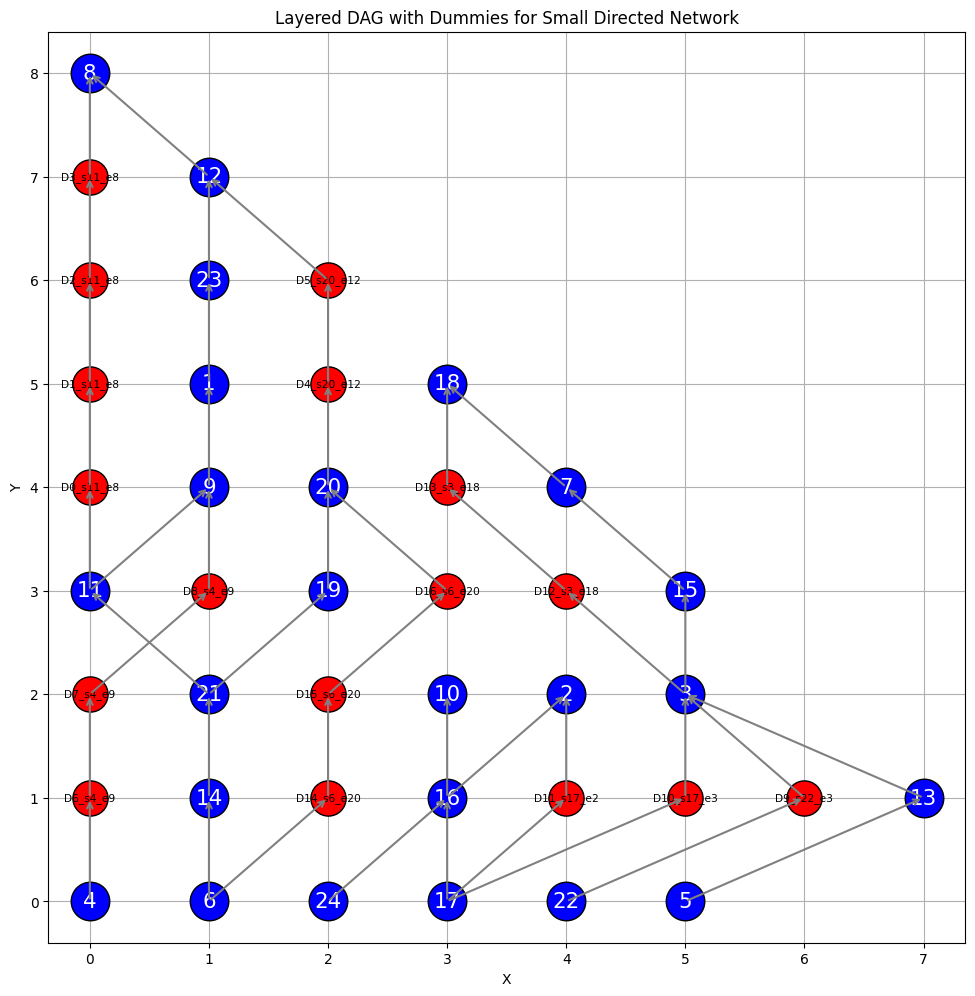

In [66]:
visualize_layerd_with_crossing(layers, layered_dummies_graph, fig_size, radius)



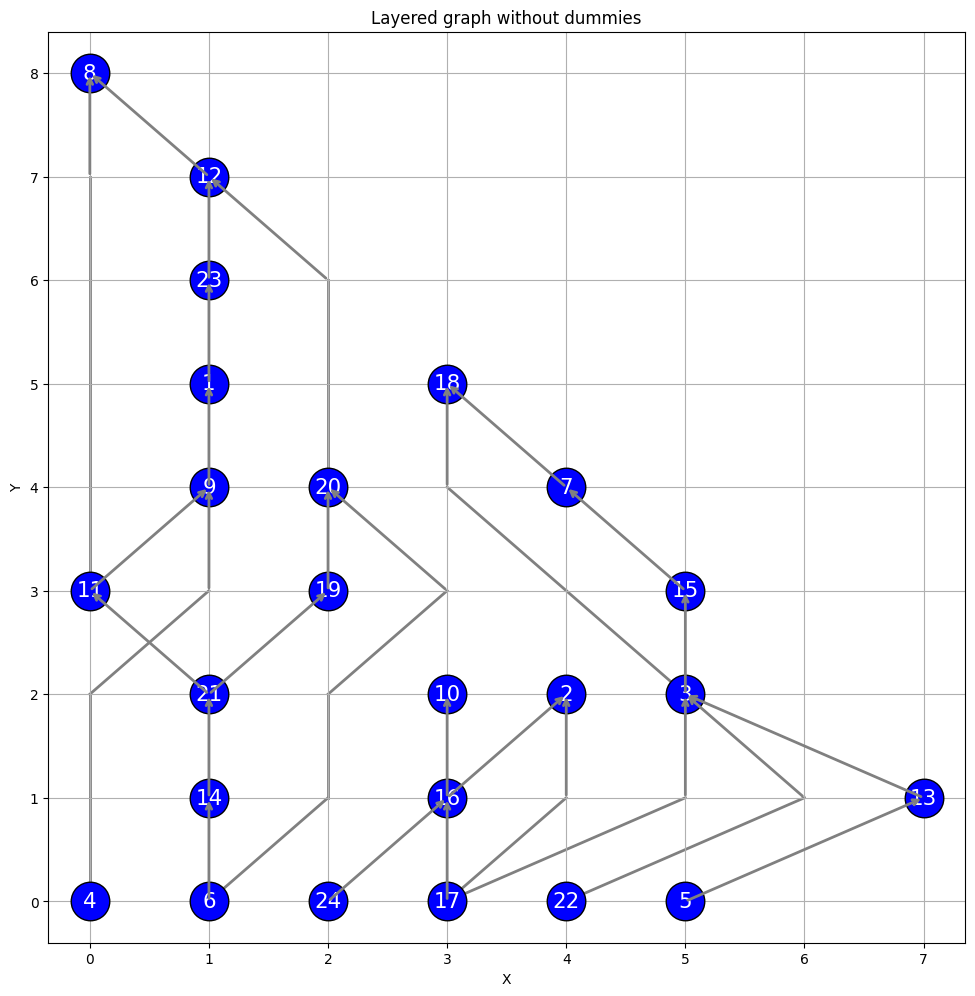

In [67]:
def visualize_layerd_with_crossing_without_dummies(layers, G, fig_size, radius):#(V^2+E)

  fig, ax = plt.subplots(figsize=(fig_size, fig_size))  # Adjust width and height as needed
  # Plot Vertices
  scaling_factor = 1 / len(G.vertices)
  for idx,layer in enumerate(layers):
      for idx1,vertex in enumerate(layer):
            #update_x_y
            G.update_x_y(vertex.id, idx1, idx)
            #if its dummy do not show it
            if vertex.id.startswith("D"):
              continue
            else:
              ax.scatter(idx1, idx, color='blue', zorder=2, s=scaling_factor * 40000 * (fig_size / 15),
                      edgecolors='black')
              ax.text(idx1, idx, str(vertex.id), fontsize=(scaling_factor * 40000 * (fig_size / 15)) / 50,
                    ha='center', va='center', zorder=len(G.vertices) * scaling_factor * 2, color='white')


  for edge in G.edges:
      start = edge.start
      end = edge.end
      dx = end.x - start.x
      dy = end.y - start.y
      if end.id.startswith("D"):
        ax.plot([start.x, end.x], [start.y, end.y],color='gray', zorder=1, linewidth=2)
      else:
        ax.annotate("", xy=(end.x, end.y), xytext=(start.x, start.y),
                    arrowprops=dict(arrowstyle="->", linewidth=2, color='gray'))


  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_title('Layered graph without dummies')
  ax.grid(True)
  plt.show()



fig_size=5+len(layered_dummies_graph.vertices)/6 # new line
radius=5+len(layered_dummies_graph.vertices)/4 # new line
visualize_layerd_with_crossing_without_dummies(layers, layered_dummies_graph, fig_size, radius)


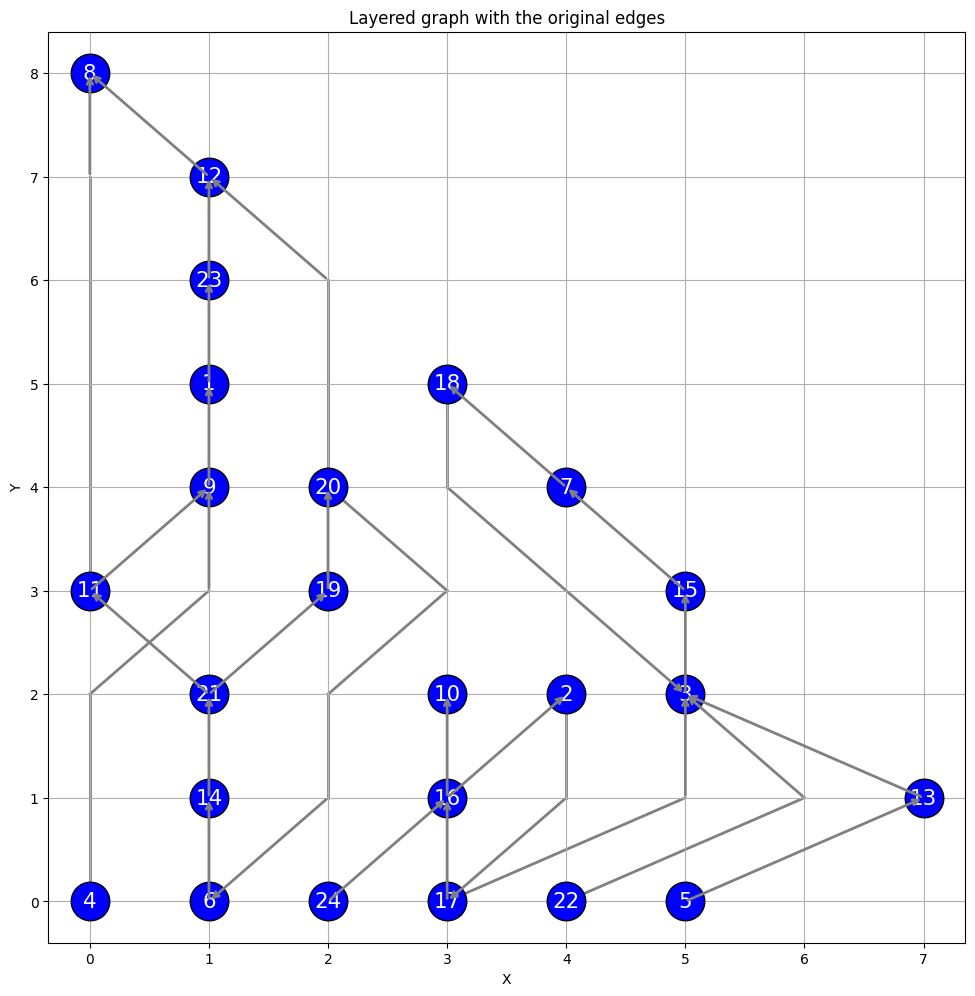

In [68]:
#REVERSE #######################################################################
def visualize_layerd_with_crossing_without_dummies(layers, G, fig_size, radius):#(V^2+E)

  fig, ax = plt.subplots(figsize=(fig_size, fig_size))  # Adjust width and height as needed
  # Plot Vertices
  scaling_factor = 1 / len(G.vertices)
  for idx,layer in enumerate(layers):
      for idx1,vertex in enumerate(layer):

          # G.update_x_y(vertex.id, idx1, idx)

          if vertex.id.startswith("D"):
            continue
          else:
            ax.scatter(idx1, idx, color='blue', zorder=2, s=scaling_factor * 40000 * (fig_size / 15),
                    edgecolors='black')
            ax.text(idx1, idx, str(vertex.id), fontsize=(scaling_factor * 40000 * (fig_size / 15)) / 50,
                  ha='center', va='center', zorder=len(G.vertices) * scaling_factor * 2, color='white')



  for edge in G.edges:
      start = edge.start
      end = edge.end

      for rev in reverse_edges:
        if (("s"+rev.end.id+"_e"+rev.start.id) in start.id) or (("s"+rev.end.id+"_e"+rev.start.id) in end.id) or (start.id == rev.end.id and end.id == rev.start.id):
          x = start
          start = end
          end = x

      dx = end.x - start.x
      dy = end.y - start.y
      if end.id.startswith("D"):

        ax.plot([start.x, end.x], [start.y, end.y],color='gray', zorder=1, linewidth=2)
      else:
        ax.annotate("", xy=(end.x, end.y), xytext=(start.x, start.y),
                      arrowprops=dict(arrowstyle="->", linewidth=2, color='gray'))


  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_title('Layered graph with the original edges')
  ax.grid(True)
  plt.show()



fig_size=5+len(layered_dummies_graph.vertices)/6 # new line
radius=5+len(layered_dummies_graph.vertices)/4 # new line
visualize_layerd_with_crossing_without_dummies(layers, layered_dummies_graph, fig_size, radius)
